# Necessary Imports
* We use tensorflow for keras and vgg19
* We use pandas for manipulating data
* We use os for filepaths
* Tqdm is not necessary but helpful for visualization
* Seaborn is nice for visualization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path
import re 
import tensorflow as tf
from tensorflow import keras 
from keras import layers 
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.regularizers import l2
from keras.applications.vgg19 import preprocess_input
from sklearn.metrics import precision_score, recall_score
from os import listdir
from os.path import isfile, join
import os.path as osp
from PIL import Image

# Verify CUDA Installation

In [2]:
print ("CUDA Availability:", tf.test.is_built_with_cuda())
print ("GPU Availability", tf.test.is_gpu_available())

CUDA Availability: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Availability True


# Verify GPU Utilization
* CUDA v12.3 must be installed and configured
* CuDNN v8.9 must be installed and configured

In [3]:
if tf.test.gpu_device_name():
    print("Default GPU Device:{}".format(tf.test.gpu_device_name()))
else: 
    print("Please install GPU version of TF") 

Default GPU Device:/device:GPU:0


<h1>1) Run the Following Cell</h1>

* This imports needed Keras libraries
* Then, it gets the trained VGG19 imagenet model with the prediction layer turned off, because it is not needed for the images in this program
* Then, it prints out the names of all the layers in that model

In [4]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.utils import load_img
from keras.models import Model

base_model = VGG19(weights='imagenet',include_top=False, input_shape=(224,224,3))
xs,ys=224,224

for layer in base_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


<h2>Preparing VGG19 model</h2>

In this program we will be using the block5_conv4 layer as the output layer because it will extract the greatest amount of detail from the images.

In [5]:
layer = 'block5_conv4'

model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)

## Load the CSV File
This CSV file contains the filename, and the emotion label.

In [6]:
directory = 'archive/images'
path = Path(directory)

emotions_images = list(path.glob('*.jpg'))
emotions_name = [os.path.split(x)[1] for x in list(path.glob('*.jpg'))]
image_df = pd.concat([pd.Series(emotions_name, name='Name'), pd.Series(emotions_images, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

emotions_df = pd.read_csv('labels.csv')

joined_df = image_df.merge(emotions_df, on='Name')

joined_df = joined_df.drop(['Name'], axis=1)
joined_df.head()

,Filepath,Type1
0,archive\images\PrivateTest_10072988.jpg,surprise
1,archive\images\PrivateTest_10077120.jpg,happy
2,archive\images\PrivateTest_10086748.jpg,neutral
3,archive\images\PrivateTest_10089743.jpg,surprise
4,archive\images\PrivateTest_10131363.jpg,angry


# Perform Preprocessing on Dataset

In [7]:
# shuffle the data
joined_df = joined_df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_data = train_gen.flow_from_dataframe(
    joined_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training',
    shuffle=True
)

val_data = train_gen.flow_from_dataframe(
    joined_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation',
    shuffle = True
)
     


Found 28710 validated image filenames belonging to 7 classes.
Found 7177 validated image filenames belonging to 7 classes.


# Configure the Model

In [8]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.00013))(x)  # L2 regularization
x = tf.keras.layers.Dropout(0.5999)(x)  # Dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.00013))(x)  # L2 regularization
x = tf.keras.layers.Dropout(0.5999)(x)  # Dropout



num_classes = 7  # Update this value to match the number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)  # Use softmax activation for multi-class classification


model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of the VGG19 base model
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Recompile the model after updating layer trainability
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000089),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=30)
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

epochs = 145

# Fit the Model

In [10]:
model.fit(train_data,
          validation_data=val_data,
          batch_size=29,
          epochs=epochs,
          callbacks=[early_stopping, checkpoint])

model.save('VGG19.keras')

Epoch 1/145
898/898 [==============================] - ETA: 0s - loss: 1.8770 - accuracy: 0.2332
Epoch 1: val_accuracy improved from -inf to 0.25024, saving model to best_model.h5
898/898 [==============================] - 456s 507ms/step - loss: 1.8770 - accuracy: 0.2332 - val_loss: 1.8412 - val_accuracy: 0.2502
Epoch 2/145
898/898 [==============================] - ETA: 0s - loss: 1.8575 - accuracy: 0.2404
Epoch 2: val_accuracy did not improve from 0.25024
898/898 [==============================] - 404s 449ms/step - loss: 1.8575 - accuracy: 0.2404 - val_loss: 1.8432 - val_accuracy: 0.2502
Epoch 3/145
898/898 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.2452
Epoch 3: val_accuracy did not improve from 0.25024
898/898 [==============================] - 400s 445ms/step - loss: 1.8440 - accuracy: 0.2452 - val_loss: 1.8296 - val_accuracy: 0.2502
Epoch 4/145
898/898 [==============================] - ETA: 0s - loss: 1.7488 - accuracy: 0.2882
Epoch 4: val_accuracy 

# Show a sample of the predictions

In [2]:
image = load_img('testImages/image3.jpg', target_size=(244, 244))

image_resized = image.resize((224, 224))

# show the image
plt.imshow(image)

# predict the image using the model
predictions = model.predict(np.expand_dims(image, axis=0))
predicted_classes = np.argmax(predictions, axis=1)
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
print(class_names[predicted_classes.item()])


NameError: name 'load_img' is not defined

1/1 [==============================] - 0s 307ms/step
True labels:  [3. 0. 3. 3. 6. 5. 5. 5. 5. 6. 5. 4. 0. 0. 2. 5. 2. 3. 3. 0. 0. 4. 2. 5.
 5. 3. 5. 5. 0. 0. 5. 3.]
Predicted labels:  [3 0 3 3 6 0 5 2 5 6 4 4 4 5 2 5 6 2 3 5 2 5 5 2 5 0 5 4 5 2 2 3]


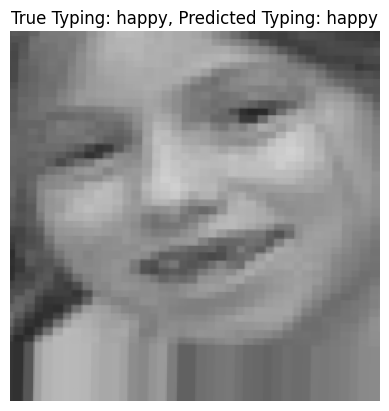

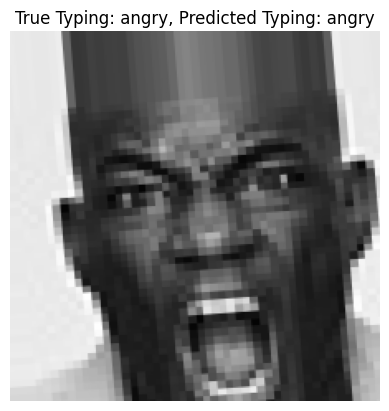

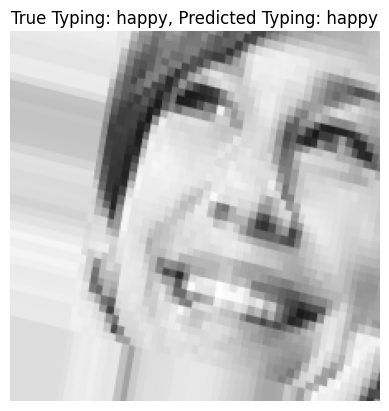

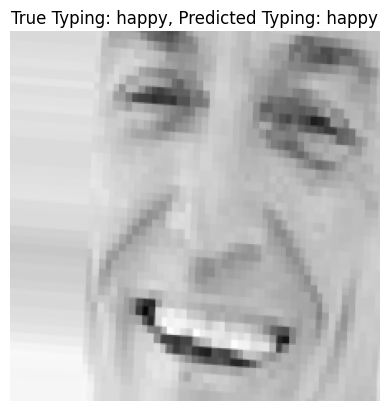

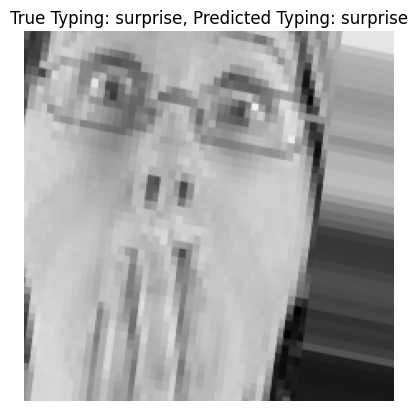

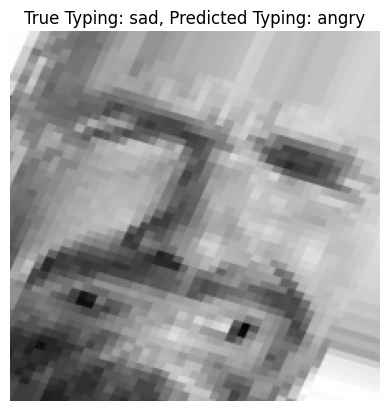

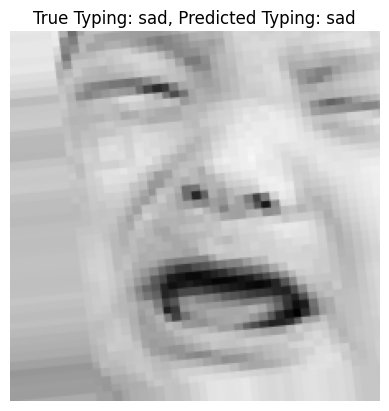

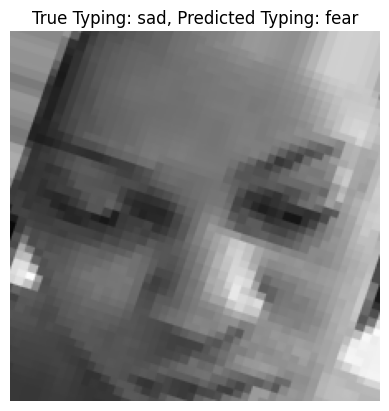

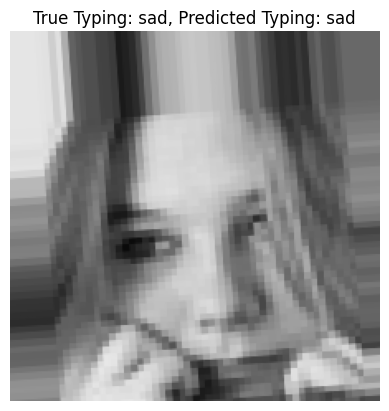

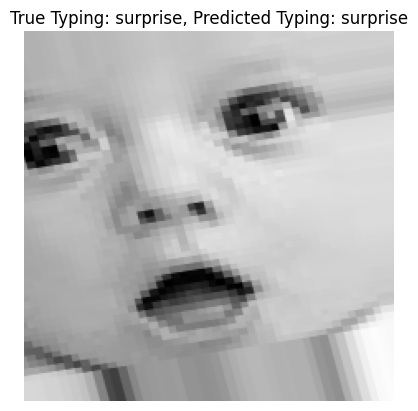

In [11]:
# Resize validation data to match the expected shape of the model
x_val_sample, y_val_sample = next(val_data)
x_val_sample_resized = tf.image.resize(x_val_sample, (224, 224))

class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Make predictions on resized validation data
predictions = model.predict(x_val_sample_resized)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print true labels and predicted labels
print("True labels: ", y_val_sample)
print("Predicted labels: ", predicted_classes)

# Display a few images and their true/predicted labels
num_images_to_display = 10

class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
y_val_sample = y_val_sample.astype(int)

for i in range(num_images_to_display):
    plt.imshow(x_val_sample[i])
    true_label = class_names[y_val_sample[i]]
    predicted_label = class_names[predicted_classes[i]]
    plt.title(f"True Typing: {true_label}, Predicted Typing: {predicted_label}")
    plt.axis('off')
    plt.show()



## Evaluate the Model

In [39]:
precision = precision_score(true_label, predicted_label, average='weighted')
recall = recall_score(true_label, predicted_label, average = 'weighted')

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')

InvalidParameterError: The 'y_true' parameter of precision_score must be an array-like or a sparse matrix. Got 'surprise' instead.